# Variational Autoencoder

变分自编码器（Variational Autoencoder，VAE）的结构和AE相似，都是使用编码器对输入进行压缩，再通过解码器重建。与AE不同的是，VAE是一个生成模型而不是编码模型，它反而和GAN中的生成器是一个原理。假设数据的生成是通过一个随机分布的隐变量$z$控制。即首先从一个容易采样的分布$P_\theta(z)$中采样出$z$，再训练一个函数$f(z)$，输出条件分布$P_\theta(x | z)$，从其中采样得到$x$。据此，我们可以学习到输入数据$x$的概率分布$P_\theta (x)$，根据输入样本最大化对数似然$\log P_\theta(x)$。

然而，要得到$P_\theta(x)$，则必须对隐变量$z$积分，或是计算$P_\theta(x\mid z)$在$P(z)$上的期望

$$
P_\theta(x) = \int_z P_\theta(x\mid z)P(z) \mathrm dz = \mathbb E_{z\sim P(z)} P_\theta(x\mid z)
$$

在一些简单的场景下，如$z$为离散数值，$P(x\mid z)$为高斯分布时，可以推导出$P(x)$为混合高斯分布。然而，在更加一般的条件下，$P(x \mid z)$通常是复杂的函数，使得我们难以通过积分的方式计算$P(x)$。另外，$z$也往往是高维变量，维度诅咒的问题也使得直接从先验分布$P(z)$中采样的方式估计$P(x) = \mathbb E_{z\sim P(z)} P_\theta(x\mid z)$的效率很低，模型难以收敛。在GAN中，我们通过一个判别器对生成器$P(x \mid z)$的优化方向给出指导。相对地，VAE提出根据观测数据$x$估计得到的隐变量$z$的分布，即 **变分分布** $q_{\phi}(z\mid x)$ 以提高采样效率，$\phi$为变分参数。引入变分分布后：

$$
\begin{aligned}
\log P_\theta(x) &= \mathbb E_{z\sim q_\phi(z\mid x)}\log P_\theta(x) \\
&= \mathbb E_{z\sim q_\phi(z\mid x)} \log\frac{P_\theta(x, z)}{P_{\theta}(z\mid x)} \\
&= \mathbb E_{z\sim q_\phi(z\mid x)} \log\frac{P_\theta(x, z)}{q_{\phi}(z\mid x)} + \log\frac{q_\phi (z\mid x)}{P_{\theta}(z\mid x)} \\
&= \mathbb E_{z\sim q_\phi(z\mid x)} [\log P_\theta(x, z) -\log q_{\phi}(z\mid x)] + \text{KL}(q_\phi (z\mid x)\Vert P_{\theta}(z\mid x))
\end{aligned}
$$

我们的优化目标是最大化$\log P_\theta(x)$。由于$\text{KL}(q_\phi (z\mid x)\Vert P_{\theta}(z\mid x))\geq 0$，有$\log P_\theta(x)\geq \mathbb E_{z\sim q_\phi(z\mid x)} [\log P_\theta(x, z) -\log q_{\phi}(z\mid x)]$。因此：

1. $\mathbb E_{z\sim q_\phi(z\mid x)} [\log P_\theta(x, z) -\log q_{\phi}(z\mid x)]$是对数似然的一个下界
2. 当$q_\phi (z\mid x)$更接近$z$的真实后验分布$P_{\theta}(z\mid x)$时，KL散度趋近于0。随着优化过程的进行，这个下界逐渐越紧，$P(x \mid z)q_{\phi}(z\mid x)$更接近真实的联合分布$P(x, z)$。

将该下界称为Evidence Lower Bound，ELBO，它可以被表示为：

$$
\begin{aligned}
\text{ELBO} &= \mathbb E_{z\sim q_\phi(z\mid x)} [\log P_\theta(x, z) -\log q_{\phi}(z\mid x)] \\
&= \mathbb E_{z\sim q_\phi(z\mid x)} \left[\log P_\theta(x\mid z) -\log \frac{q_{\phi}(z\mid x)}{P_\theta(z)}\right] \\
&= \underbrace{\mathbb E_{z\sim q_\phi(z\mid x)} [\log P_\theta(x\mid z)]}_{\text{optimize reconstruction error}} - \underbrace{\text{KL}(q_\phi (z\mid x)\Vert P_{\theta}(z))}_{\text{optimize variational distribution}}
\end{aligned}
$$

通常假设，$z$的先验分布为标准正态分布$\mathcal N(0, I)$。因此，最大化ELBO的训练目标中包含使变分分布$q_{\phi}(z\mid x)$的输出逐渐接近标准正态分布的目标。一般令VAE的编码器得到$z$的变分分布，是各变量相互独立的高斯分布。由于先验分布和变分分布都是正态分布，当两个分布均为正态分布时，它们的KL散度有解析解，由于各个分量相互独立，考虑一元分布的情况：

$$
\begin{aligned}
& \text{KL}(\mathcal N(\mu, \sigma^2)\Vert \mathcal N(0, 1)) \\
=& \int_{-\infty}^\infty \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}} \log\frac{\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}}{\frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}}\mathrm dx \\
=& \int_{-\infty}^\infty \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}\left[\log\frac{1}{\sqrt{2\pi\sigma^2}} - \frac{(x - \mu)^2}{2\sigma^2} - \log\frac{1}{\sqrt{2\pi}} + \frac 12 x^2\right] \mathrm dx\\
=& \int_{-\infty}^\infty \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}\left[-\log\sigma - \frac{(x - \mu)^2}{2\sigma^2} + \frac{1}{2} x^2\right] \mathrm dx \\
=& -\log\sigma - \frac{\mathbb E\left[(x - \mu)^2\right]}{2\sigma^2} + \frac 12\mathbb E\left(x^2\right) \\
=& \frac{1}{2}\left(\mu^2 + \sigma^2 - 1 -\log\sigma^2\right) \\
\end{aligned}
$$

解码器得到$x\mid z$的概率分布，也是各变量相互独立的高斯分布，这样$P(x) = P(z) P(x \mid z)$也是高斯分布。对于高斯分布而言，模型只需要输出该分布的均值$\mu$和对数方差$\log\sigma^2$即可，或是固定方差$\sigma^2$，模型只输出均值。将输入的样本代入分布中，即可计算重建损失项$\mathbb E_{z\sim q_\phi(z\mid x)} [\log P_\theta(x\mid z)]$中的对数似然。$z$可以通过从变分分布中采样的方式获得，根据$z$和$x$计算得到ELBO。但采样过程不可微，无法进行梯度的反向传播。为了保证梯度能够反向传播到变分分布中，常用的方法是重参数化（reparameterization）。即从一个标准正态分布中采样一个噪声$\varepsilon$，用$\mu + \sigma^2 I\cdot \varepsilon$作为$z$的采样。

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader

# SVG output
%config InlineBackend.figure_format = 'svg'

# Fix for certificate error
# https://stackoverflow.com/questions/71263622
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

导入MNIST数据集，使用VAE生成手写数字图片。

In [2]:
train_dataset = torchvision.datasets.MNIST(
    train=True, root='data',
    transform=torchvision.transforms.ToTensor(), download=True
)
test_dataset = torchvision.datasets.MNIST(
    train=True, root='data',
    transform=torchvision.transforms.ToTensor(), download=True
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=8)

VAE中的解码器扮演和GAN中生成器相近的角色，接受$d$维的隐向量$z$并输出$x$的概率分布。注意输出中包含两个通道，第一个通道为均值，第二个通道为对数标准差。

In [3]:
class Reshape(torch.nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

class Decoder(torch.nn.Module):
    def __init__(self, hidden_size: int):
        super(Decoder, self).__init__()
        self.fcn = torch.nn.Sequential(
            torch.nn.Linear(in_features=hidden_size, out_features=32 * 7 * 7),
            torch.nn.LeakyReLU(0.2),
            Reshape(32, 7, 7),
        )

        self.deconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=32,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.ConvTranspose2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(
                in_channels=128, out_channels=2, kernel_size=(3, 3), padding=(1, 1)
            ),
            torch.nn.Tanh(),
        )
        self.layers = torch.nn.Sequential(self.fcn, self.deconv)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

编码器与解码器相反，编码器输出两个维度为$d$的向量来表示$z$的分布。

In [4]:
class Encoder(torch.nn.Module):
    def __init__(self, hidden_size: int):
        super(Encoder, self).__init__()
        self.conv = torch.nn.Sequential(
            Reshape(1, 28, 28),
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
        )
        self.classifier = torch.nn.Sequential(
            Reshape(3136),
            torch.nn.Linear(in_features=3136, out_features=hidden_size * 2),
            Reshape(2, hidden_size)
        )
        self.layers = torch.nn.Sequential(self.conv, self.classifier)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

将两者组合可以得到VAE网络的结构。在VAE中，需要定义一个函数用于计算输入在给定高斯分布中的对数PDF。

In [5]:
class VAE(torch.nn.Module):
    def __init__(self, hidden_size: int):
        super(VAE, self).__init__()
        self.hidden_size = hidden_size
        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size)
        self.device = torch.device('cpu')

        self.log_2pi = torch.log(torch.tensor(2 * torch.pi, dtype=torch.float32))

    def to(self, *args, **kwargs):
        if args:
            self.device = args[0]
        elif 'device' in kwargs:
            self.device = kwargs['device']
        super().to(*args, **kwargs)

    def log_norm_pdf(self, x: torch.Tensor, mean: torch.Tensor, logvar: torch.Tensor):
        # x: [batch_size, hidden_size] or [hidden_size]
        # loc: [hidden_size]
        # shape: [hidden_size]
        if x.dim() == 1:
            x = x.unsqueeze(0)
        batch_size = x.size(0)
        x = x.reshape(batch_size, -1)
        mean = mean.reshape(batch_size, -1)
        logvar = logvar.reshape(batch_size, -1)
        n_vars = x.size(1)

        exp = -0.5 * ((x - mean) ** 2 / torch.exp(logvar)).sum(dim=1)
        return -0.5 * (logvar.sum(dim=1) + n_vars * self.log_2pi) + exp

    def forward(
        self, x: torch.Tensor
    ):
        x = x.to(self.device)
        latent_dist = self.encoder(x)
        z_mu, z_logsigma = latent_dist[:, 0], latent_dist[:, 1]
        randn = torch.randn(x.size(0), self.hidden_size, device=self.device)
        z = z_mu + torch.exp(z_logsigma) * randn

        x_dist = self.decoder(z)
        x_mu, x_logsigma = x_dist[:, 0], x_dist[:, 1]
        log_likelihood = self.log_norm_pdf(x, x_mu, x_logsigma * 2)
        kl_div = self.log_norm_pdf(z, z_mu, z_logsigma) - \
            self.log_norm_pdf(z, torch.zeros_like(z_mu), torch.zeros_like(z_logsigma))
        return kl_div.mean(), log_likelihood.mean()

model = VAE(hidden_size=8)

从测试集中选出10个数字的图片

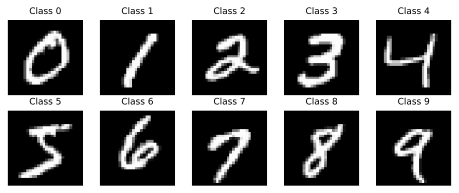

In [6]:
from matplotlib.axes import Axes
from matplotlib import pyplot as plt
from typing import Optional

test_input = {}
for (x, y) in test_loader:
    if len(test_input) == 10:
        break
    size = y.size(0)
    for _ in range(size):
        if y[_].item() in test_input:
            continue
        test_input[y[_].item()] = x[_].detach()

def plot_image(x: torch.Tensor, ax: Optional[Axes] = None):
    img = x.view(28, 28).cpu().numpy()

    if ax is None:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    else:
        ax.imshow(img, cmap='gray')
        ax.axis('off')


fig, ax = plt.subplots(2, 5, figsize=(8, 3))
axes = ax.flatten()
for i, ax in enumerate(axes):
    ax.set_title(f'Class {i}', fontsize=9)
    plot_image(test_input[i], ax)
plt.show()

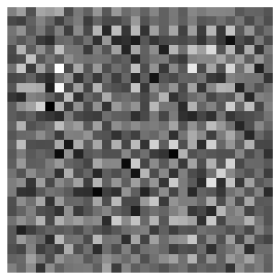

In [7]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from typing import Optional

def plot_decoder(model: VAE, z: Optional[torch.Tensor] = None, ax: Optional[Axes] = None):
    if z is None:
        z = torch.randn(1, model.hidden_size, device=model.device)
    else:
        z = z.to(model.device)
    with torch.no_grad():
        x = model.decoder(z)[:, 0].view(28, 28).cpu() * 0.5 + 0.5

    plot_image(x, ax)

plot_decoder(model)
plt.show()

设置训练过程中的超参数。

In [8]:
N = 20
K_plot = 2
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = 'cuda:5' if torch.cuda.is_available() else 'cpu'  # CUDA
model.to(device)

# Record training metrics
z_noise = torch.randn(10, model.hidden_size)
step = 0
train_metrics = []

开始训练，每隔2个epoch绘制神经网络对图片的重建效果。

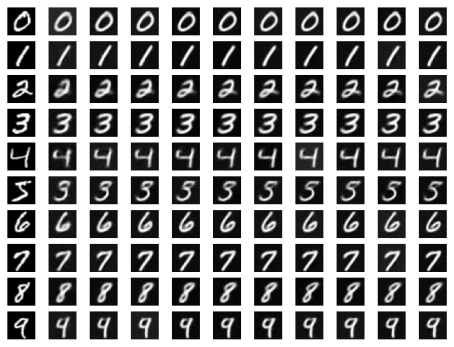

In [9]:
from typing import Dict, Iterator, List

fig, ax_grid = plt.subplots(10, N // K_plot + 1, figsize=(8, 6))
axes = iter(ax_grid.T)

def plot_column(axes: Iterator[List[Axes]], samples: Dict[int, torch.Tensor]):
    ax_column = next(axes)
    for i, x_sample in samples.items():
        plot_image(x_sample, ax_column[i])

plot_column(axes, test_input)

for epoch in range(N):
    step_metric = {}
    for x, _ in train_loader:
        model.train()
        step += 1
        optimizer.zero_grad()
        kl, log_likelihood = model(x)
        step_metric['kl'] = kl.item()
        step_metric['nll'] = -log_likelihood.item()
        loss = kl - log_likelihood
        loss.backward()
        optimizer.step()

        train_metrics.append(step_metric)
        step_metric = {}

    if (epoch + 1) % K_plot == 0:
        model.eval()
        decoder_output = {}
        for i, x_sample in test_input.items():
            x_sample = x_sample.to(model.device)
            z_mu = model.encoder(x_sample)[:, 0]
            x_mu = model.decoder(z_mu)[0, 0]
            decoder_output[i] = x_mu.detach()
        plot_column(axes, decoder_output)

fig.show()

In [10]:
from typing import Any, Dict, Iterable, List, Tuple
import random

def extract_metrics(data: List[Dict[str, Any]], field: str) -> Tuple[List[int], List[Any]]:
    x, y = [], []
    for step, record in enumerate(data, start=1):
        if field in record:
            x.append(step)
            y.append(record[field])
    return x, y

def ema(x, beta):
    y = x[0]
    for _ in x:
        y = beta * y + (1 - beta) * _
        yield y

def sample(x: Iterable[Any], y: Iterable[Any], ratio: float):
    result_x, result_y = [], []
    for x_sample, y_sample in zip(x, y):
        if random.random() < ratio:
            result_x.append(x_sample)
            result_y.append(y_sample)
    return result_x, result_y

绘制训练过程的KL散度和重建损失变化。注意当隐向量维度较高时，采样空间很大，使得KL散度往往会维持在一个较高的水平上。但更高维度的隐向量同时具备更好的表达能力，重建的图片更加清晰。

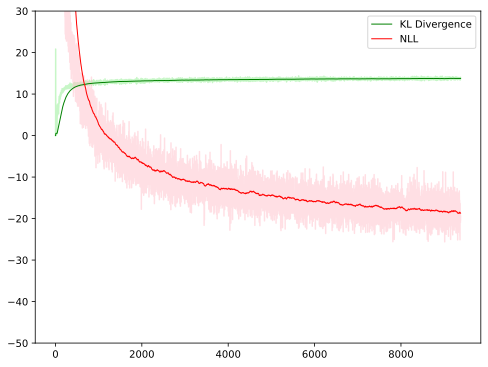

In [11]:
fig, ax1 = plt.subplots(figsize=(8, 6))

x_kl, y_kl = extract_metrics(train_metrics, 'kl')
x_log_ll, y_log_ll = extract_metrics(train_metrics, 'nll')

ax1.plot(x_kl, y_kl, color='lightgreen', alpha=0.5)
ax1.plot(x_log_ll, y_log_ll, color='pink', alpha=0.5)
ax1.plot(x_kl, [*ema(y_kl, 0.99)], label='KL Divergence', color='green', linewidth=1)
ax1.plot(x_log_ll, [*ema(y_log_ll, 0.99)], label='NLL', color='red', linewidth=1)

ax1.legend()
ax1.set_ylim(-50, 30)

fig.show()

过大的KL散度往往会导致将随机噪声输入解码器，解码的结果和真实的手写字符差异很大。

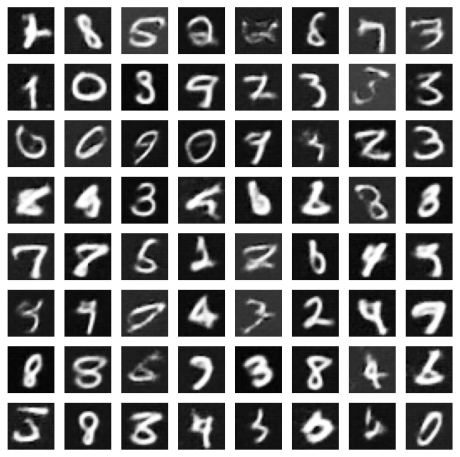

In [12]:
fix, ax = plt.subplots(8, 8, figsize=(8, 8))
for i, _ in enumerate(ax.flatten()):
    plot_decoder(model, ax=_)

可以对隐向量进行插值，观察插值后的数值变化。

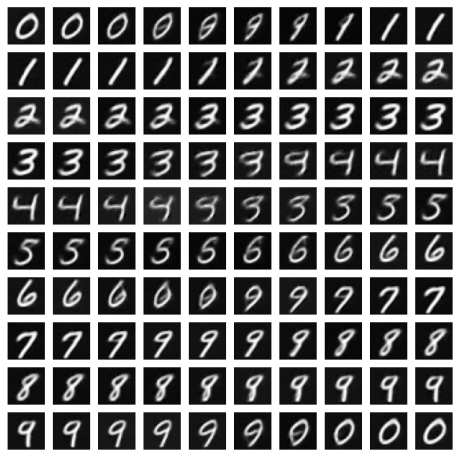

In [13]:
fix, ax = plt.subplots(10, 10, figsize=(8, 8))
z = {
    i: model.encoder(sample.unsqueeze(0).to(model.device))[:, 0]
    for i, sample in test_input.items()
}
for i in range(10):
    for j in range(10):
        left = z[i]
        right = z[(i + 1) % 10]
        interpolated = (1 - j / 9) * left + (j / 9) * right
        plot_decoder(model, interpolated, ax[i, j])